In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install missingno
import missingno as msno

In [2]:
# train data 불러오기
df_train = pd.read_csv("../data/train_heat.csv", index_col=0)
df_train

,train_heat.tm,train_heat.branch_id,train_heat.ta,train_heat.wd,train_heat.ws,train_heat.rn_day,train_heat.rn_hr1,train_heat.hm,train_heat.si,train_heat.ta_chi,train_heat.heat_demand
1,2021010101,A,-10.1,78.3,0.5,0.0,0.0,68.2,-99.0,-8.2,281
2,2021010102,A,-10.2,71.9,0.6,0.0,0.0,69.9,-99.0,-8.6,262
3,2021010103,A,-10.0,360.0,0.0,0.0,0.0,69.2,-99.0,-8.8,266
4,2021010104,A,-9.3,155.9,0.5,0.0,0.0,65.0,-99.0,-8.9,285
5,2021010105,A,-9.0,74.3,1.9,0.0,0.0,63.5,-99.0,-9.2,283
...,...,...,...,...,...,...,...,...,...,...,...
499297,2023123119,S,3.2,233.5,0.4,2.5,0.0,91.5,-99.0,2.8,34
499298,2023123120,S,2.9,227.4,0.1,2.5,0.0,92.1,-99.0,2.7,35
499299,2023123121,S,2.1,360.0,0.0,2.5,0.0,93.3,-99.0,1.4,35
499300,2023123122,S,2.2,30.0,1.4,2.5,0.0,95.5,-99.0,1.3,40


In [4]:
# 변수명 정리
df_train.columns = [col.replace("train_heat.", "") for col in df_train.columns]

In [5]:
# tm 변수 datetime 처리
df_train['tm'] = pd.to_datetime(df_train['tm'].astype(str), format='%Y%m%d%H')

In [7]:
# -99 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']


In [8]:
# -99.0을 np.nan으로 바꾸기
df_train[cols_with_neg99] = df_train[cols_with_neg99].replace(-99.0, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -99.0).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: []


In [9]:
# -9.9 포함 여부 확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-99.0' 포함 열:", cols_with_neg99)

'-99.0' 포함 열: ['ta', 'wd', 'ta_chi']


In [10]:
# -9.9를 np.nan으로 바꾸기
df_train['wd'] = df_train['wd'].replace(-9.9, np.nan)

# np.nan으로 변경 후, 포함 여부 재확인
cols_with_neg99 = [col for col in df_train.columns if (df_train[col] == -9.9).any()]
print("'-9.9' 포함 열:", cols_with_neg99)

'-9.9' 포함 열: ['ta', 'ta_chi']


In [11]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

             Missing Count  Missing Ratio (%)
si                  232922          46.649616
hm                   39717           7.954520
wd                   20404           4.086513
rn_hr1               19154           3.836163
ws                   18815           3.768268
rn_day               18626           3.730415
ta                   12997           2.603039
heat_demand             23           0.004606
ta_chi                  20           0.004006


In [12]:
# 타겟 변수 heat_demand에 결측이 있는 행 제거
df_train = df_train.dropna(subset=['heat_demand']).reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499278 entries, 0 to 499277
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           499278 non-null  datetime64[ns]
 1   branch_id    499278 non-null  object        
 2   ta           486283 non-null  float64       
 3   wd           478876 non-null  float64       
 4   ws           480465 non-null  float64       
 5   rn_day       480654 non-null  float64       
 6   rn_hr1       480126 non-null  float64       
 7   hm           459567 non-null  float64       
 8   si           266370 non-null  float64       
 9   ta_chi       499258 non-null  float64       
 10  heat_demand  499278 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 41.9+ MB


In [13]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [14]:
df_train['year'] = df_train['tm'].dt.year # 연도
df_train['quarter'] = df_train['tm'].dt.quarter # 분기별
df_train['month'] = df_train['tm'].dt.month # 월
df_train['day'] = df_train['tm'].dt.day # 월
df_train['hour'] = df_train['tm'].dt.hour
df_train['day_of_week'] = df_train['tm'].dt.dayofweek # 요일
df_train['season'] = df_train['month'].apply(get_season) # 계절
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday') # 주말 여부
df_train['weekofyear'] = df_train['tm'].dt.isocalendar().week # 주차

# 3시간 단위 시간대 컬럼 생성 (0~23시 → 0~7로 구간화)
df_train['hour_group'] = (df_train['tm'].dt.hour // 3).astype(int)
hour_labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']

In [15]:
# 공통 규칙 정의

# A,B,C,F
common_night_rules_1 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 13), 21, 6),
    ((4, 13), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 12), 20, 6),
    ((10, 12), (11, 3), 19, 6),
    ((11, 3), (12, 31), 19, 7)
]

# D,E,G,H,I,J,K,S
common_night_rules_2 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 4), 20, 7),
    ((3, 4), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 4), 19, 6),
    ((11, 4), (12, 31), 19, 7)
]

# L,M,N
common_night_rules_3 = [
    ((1, 1), (2, 10), 19, 7),
    ((2, 10), (2, 25), 20, 7),
    ((2, 25), (4, 9), 20, 6),
    ((4, 9), (4, 19), 20, 5),
    ((4, 19), (8, 26), 21, 5),
    ((8, 26), (9, 4), 20, 5),
    ((9, 4), (10, 7), 20, 6),
    ((10, 7), (11, 13), 19, 6),
    ((11, 13), (12, 31), 19, 7)
]

# O
common_night_rules_4 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 2), 20, 7),
    ((3, 2), (4, 11), 20, 6),
    ((4, 11), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 1), 21, 6),
    ((9, 1), (10, 11), 20, 6),
    ((10, 11), (11, 7), 19, 6),
    ((11, 7), (12, 31), 19, 7)
]

# P
common_night_rules_5 = [
    ((1, 1), (2, 6), 19, 7),
    ((2, 6), (3, 3), 20, 7),
    ((3, 3), (4, 10), 20, 6),
    ((4, 10), (4, 13), 21, 6),
    ((4, 13), (8,30), 21, 5),
    ((8, 30), (9, 2), 21, 6),
    ((9, 2), (10, 12), 20, 6),
    ((10, 12), (11, 6), 19, 6),
    ((11, 6), (12, 31), 19, 7)
]

# Q
common_night_rules_6 = [
    ((1, 1), (2, 5), 19, 7),
    ((2, 5), (3, 5), 20, 7),
    ((3, 5), (4, 7), 20, 6),
    ((4, 7), (4, 14), 21, 6),
    ((4, 14), (8, 28), 21, 5),
    ((8, 28), (9, 3), 21, 6),
    ((9, 3), (10, 13), 20, 6),
    ((10, 13), (11, 2), 19, 6),
    ((11, 2), (12, 31), 19, 7)
]

# R
common_night_rules_7 = [
    ((1, 1), (2, 1), 19, 7),
    ((2, 1), (3, 2), 20, 7),
    ((3, 2), (4, 9), 20, 6),
    ((4, 9), (4, 15), 21, 6),
    ((4, 15), (8, 26), 21, 5),
    ((8, 26), (9, 2), 21, 6),
    ((9, 2), (10, 14), 20, 6),
    ((10, 14), (11, 8), 19, 6),
    ((11, 8), (12, 31), 19, 7)
]


# 브랜치별 야간 시간 규칙 딕셔너리
branch_night_rules = {
    'A': common_night_rules_1,
    'B': common_night_rules_1,
    'C': common_night_rules_1,
    'D': common_night_rules_2,
    'E': common_night_rules_2,
    'F': common_night_rules_1,
    'G': common_night_rules_2,
    'H': common_night_rules_2,
    'I': common_night_rules_2,
    'J': common_night_rules_2,
    'K': common_night_rules_2,
    'L': common_night_rules_3,
    'M': common_night_rules_3,
    'N': common_night_rules_3,
    'O': common_night_rules_4,
    'P': common_night_rules_5,
    'Q': common_night_rules_6,
    'R': common_night_rules_7,
    'S': common_night_rules_2
}


In [16]:
# 모든 브랜치에 대해 야간 시간 적용
for branch, rules in branch_night_rules.items():
    is_branch = df_train['branch_id'] == branch

    for (start_m, start_d), (end_m, end_d), night_start, night_end in rules:
        in_period = (
            ((df_train['month'] > start_m) | ((df_train['month'] == start_m) & (df_train['day'] >= start_d))) &
            ((df_train['month'] < end_m) | ((df_train['month'] == end_m) & (df_train['day'] <= end_d)))
        )

        if night_start > night_end:  # 자정을 넘기는 경우
            in_night = (df_train['hour'] >= night_start) | (df_train['hour'] <= night_end)
        else:
            in_night = (df_train['hour'] >= night_start) & (df_train['hour'] < night_end)

        # 조건에 맞는 행에 대해 si 값 0으로 설정
        mask = is_branch & in_period & in_night
        df_train.loc[mask, 'si'] = 0

In [17]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing Ratio (%)': df_train.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
hm              39711           7.953685
wd              20402           4.086301
rn_hr1          19152           3.835939
ws              18813           3.768041
rn_day          18624           3.730186
ta              12995           2.602758
si              10347           2.072393
ta_chi             20           0.004006


In [18]:
cluster2_branch_ids = ['A', 'D', 'H', 'P']
df_train_cluster2 = df_train[df_train['branch_id'].isin(cluster2_branch_ids)]

In [19]:
df_train_cluster2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105112 entries, 0 to 420444
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   tm           105112 non-null  datetime64[ns]
 1   branch_id    105112 non-null  object        
 2   ta           101226 non-null  float64       
 3   wd           98176 non-null   float64       
 4   ws           98948 non-null   float64       
 5   rn_day       99552 non-null   float64       
 6   rn_hr1       99424 non-null   float64       
 7   hm           97099 non-null   float64       
 8   si           95238 non-null   float64       
 9   ta_chi       105111 non-null  float64       
 10  heat_demand  105112 non-null  float64       
 11  year         105112 non-null  int32         
 12  quarter      105112 non-null  int32         
 13  month        105112 non-null  int32         
 14  day          105112 non-null  int32         
 15  hour         105112 non-null  int32    

In [20]:
# 결측치 확인
missing_df = pd.DataFrame({
    'Missing Count': df_train_cluster2.isnull().sum(),
    'Missing Ratio (%)': df_train_cluster2.isnull().mean() * 100
})

# 결측치가 있는 열만 추출
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_df)

        Missing Count  Missing Ratio (%)
si               9874           9.393789
hm               8013           7.623297
wd               6936           6.598676
ws               6164           5.864221
rn_hr1           5688           5.411371
rn_day           5560           5.289596
ta               3886           3.697009
ta_chi              1           0.000951


c:\Users\smlee\Desktop\python\.venv2\Lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


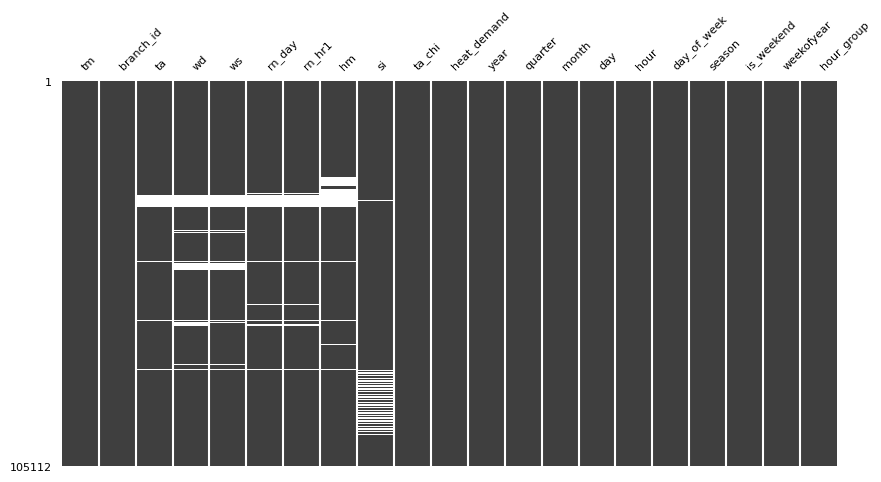

In [24]:
# 전체 결측치 matrix 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.matrix(df_train_cluster2,ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

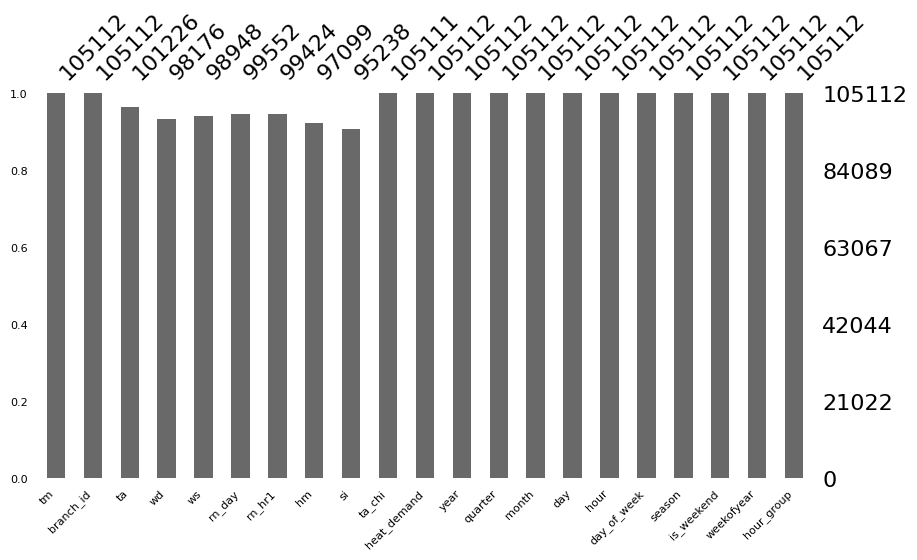

In [25]:
# 막대그래프 형태로 시각화
fig, ax = plt.subplots(figsize=(10, 5))
msno.bar(df_train_cluster2, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
plt.show()

## Target 분석

##### **(1) 일별 열수요 평균**

In [26]:
daily_avg_df_cluster2 = (
    df_train_cluster2.copy()
    .assign(date=lambda x: x['tm'].dt.date)
    .groupby('date')['heat_demand']
    .mean()
)

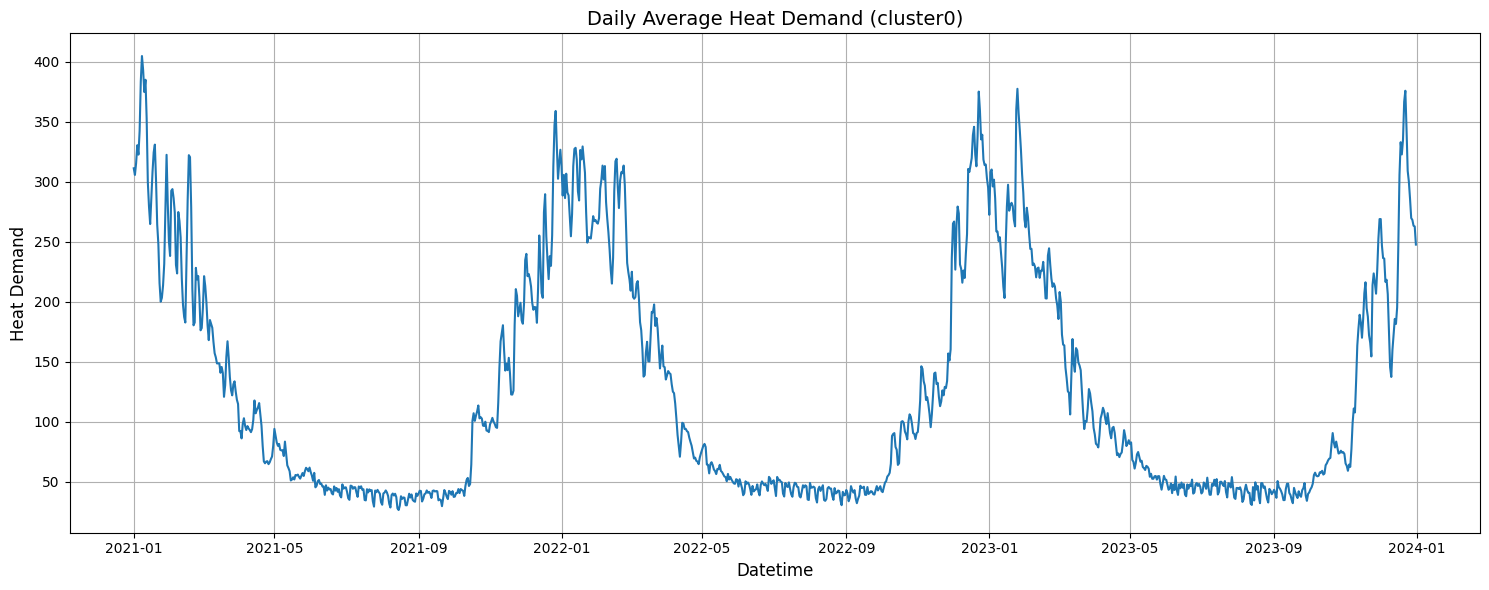

In [27]:
# 시도표
plt.figure(figsize=(15, 6))
plt.plot(daily_avg_df_cluster2.index, daily_avg_df_cluster2.values)
plt.title('Daily Average Heat Demand (cluster0)', fontsize=14)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Heat Demand', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

##### **(2) 분포 시각화**

In [48]:
def plot_heat_demand_distribution(df, column_name='heat_demand', title='Distribution of Heat Demand'):
    """
    데이터프레임과 컬럼명을 받아서 평균, 중앙값, 최빈값을 계산하고
    박스플롯과 히스토그램(분포)을 그리는 함수입니다.
    """
    mean = df[column_name].mean()
    median = df[column_name].median()
    mode = df[column_name].mode()[0]

    fig, (ax_box, ax_hist) = plt.subplots(
        2, 1,
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=(12, 6),
        sharex=True
    )

    fig.suptitle(title, fontsize=18, fontweight='bold')

    # 박스플롯
    sns.boxplot(
        x=df[column_name],
        showmeans=True,
        orient='h',
        color='lightblue',
        ax=ax_box
    )
    ax_box.set(xlabel='')

    # 히스토그램 + 평균/중앙값/최빈값 선
    sns.histplot(df[column_name], bins=100, kde=True, color='skyblue', ax=ax_hist)
    ax_hist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
    ax_hist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.1f}')
    ax_hist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.1f}')

    ax_hist.set_xlabel(column_name, fontsize=12)
    ax_hist.set_ylabel('Frequency', fontsize=12)
    ax_hist.grid(True)
    ax_hist.legend()

    plt.tight_layout()
    plt.show()


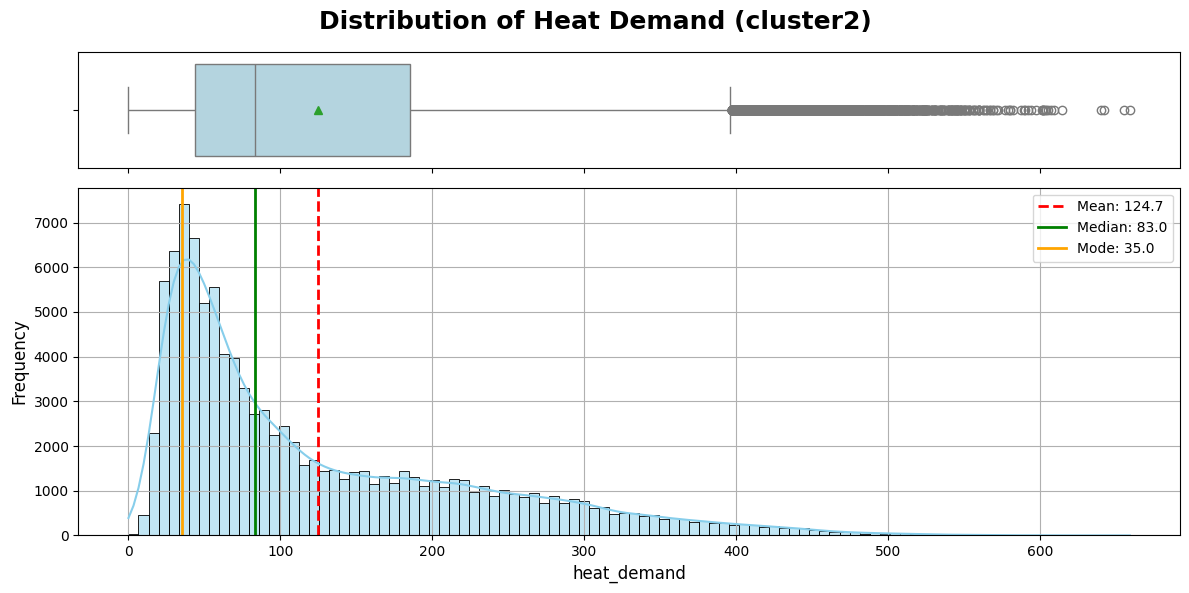

In [49]:
plot_heat_demand_distribution(df_train_cluster2, column_name='heat_demand', title='Distribution of Heat Demand (cluster2)')


-  브랜치별로 확인

In [51]:
def plot_heat_demand_distribution(df, column_name='heat_demand', title='Distribution of Heat Demand'):
    """
    데이터프레임과 컬럼명을 받아서 평균, 중앙값, 최빈값을 계산하고
    박스플롯과 히스토그램(분포)을 그리는 함수입니다.
    """
    mean = df[column_name].mean()
    median = df[column_name].median()
    mode_series = df[column_name].mode()  # 수정된 부분: Series로 받기
    
    # 모드 값 처리 (최빈값이 없을 경우 None)
    mode = mode_series[0] if not mode_series.empty else None

    fig, (ax_box, ax_hist) = plt.subplots(
        2, 1,
        gridspec_kw={"height_ratios": (.25, .75)},
        figsize=(12, 6),
        sharex=True
    )

    fig.suptitle(title, fontsize=18, fontweight='bold')

    # 박스플롯
    sns.boxplot(
        x=df[column_name],
        showmeans=True,
        orient='h',
        color='lightblue',
        ax=ax_box
    )
    ax_box.set(xlabel='')

    # 히스토그램 + 평균/중앙값/최빈값 선
    sns.histplot(df[column_name], bins=100, kde=True, color='skyblue', ax=ax_hist)
    ax_hist.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
    ax_hist.axvline(median, color='green', linestyle='-', linewidth=2, label=f'Median: {median:.1f}')
    
    # 최빈값 선 추가 (값이 있을 경우만)
    if mode is not None:
        ax_hist.axvline(mode, color='orange', linestyle='-', linewidth=2, label=f'Mode: {mode:.1f}')  # 수정된 부분

    # x축, y축 범위 통일
    ax_hist.set_xlim(0, 700)
    ax_hist.set_ylim(0, 1800)

    ax_hist.set_xlabel(column_name, fontsize=12)
    ax_hist.set_ylabel('Frequency', fontsize=12)
    ax_hist.grid(True)
    ax_hist.legend()

    plt.tight_layout()
    plt.show()


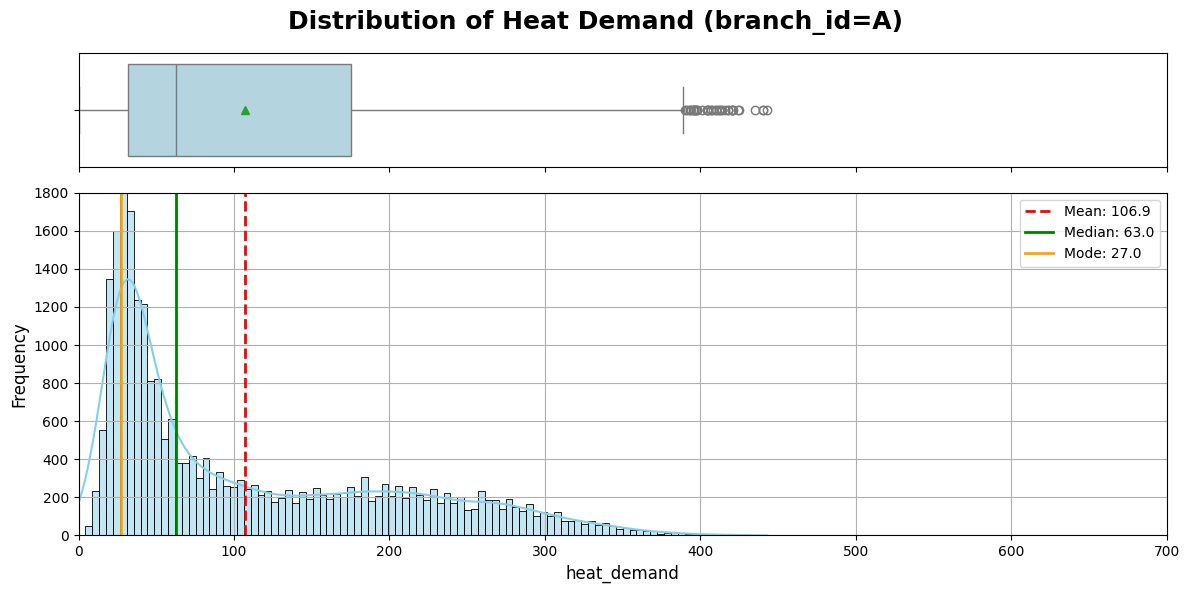

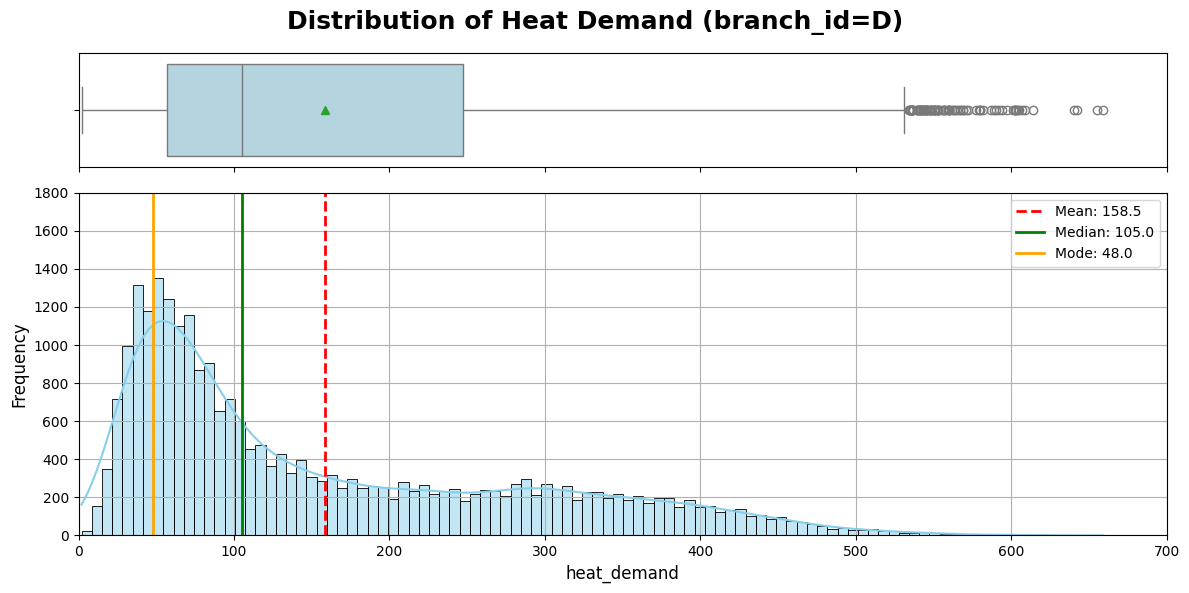

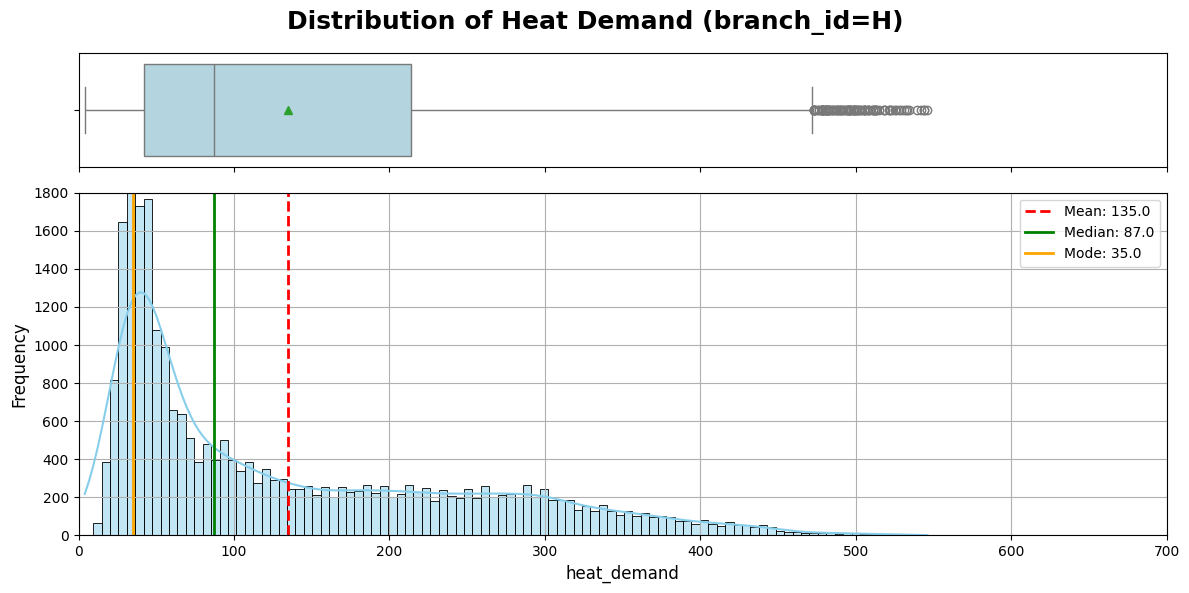

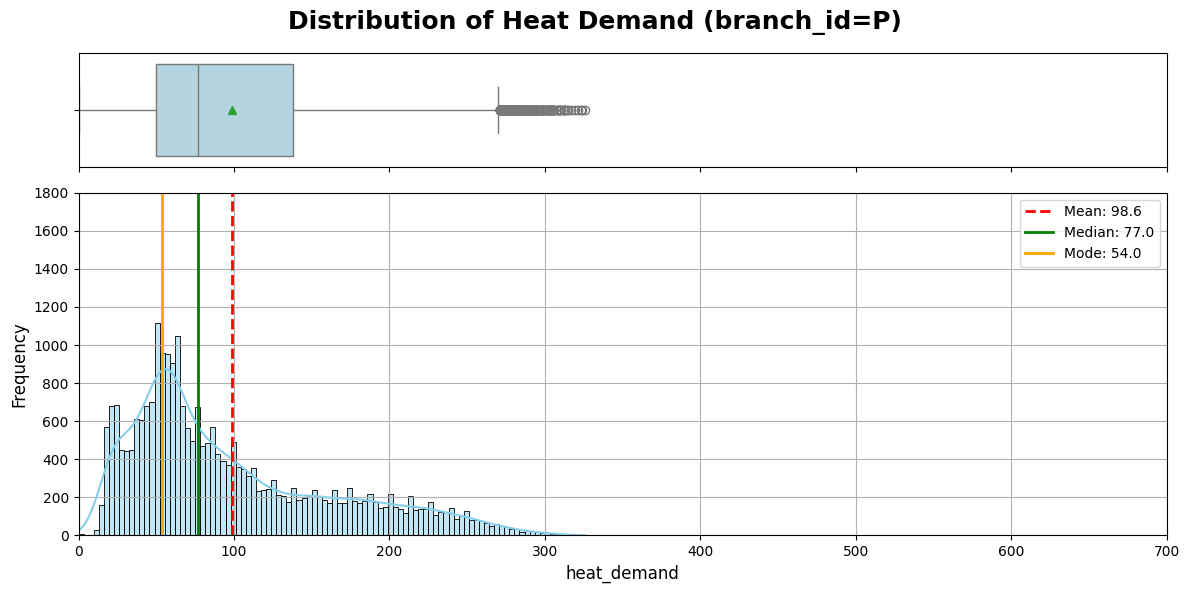

In [52]:
# branch_id별로 분포 시각화
for branch in df_train_cluster2['branch_id'].unique():
    temp_df = df_train_cluster2[df_train_cluster2['branch_id'] == branch]
    plot_heat_demand_distribution(
        temp_df,
        column_name='heat_demand',
        title=f'Distribution of Heat Demand (branch_id={branch})'
    )


- 이상치 파악

In [53]:
def find_outliers(df, column='heat_demand', threshold=350, branch_id=None):
    """
    데이터프레임에서 특정 브랜치의 이상치를 탐색하는 함수
    
    Parameters:
    - df: 분석 대상 데이터프레임
    - column: 분석 컬럼 (기본값: heat_demand)
    - threshold: 이상치 기준값 (기본값: 350)
    - branch_id: 특정 브랜치 선택 (기본값: 전체 브랜치)
    
    Returns:
    - 이상치 데이터프레임 (지정 컬럼 기준 내림차순 정렬)
    """
    # 브랜치 선택
    if branch_id is not None:
        df = df[df['branch_id'] == branch_id]
    
    # 이상치 필터링 및 정렬
    outliers = df[df[column] >= threshold]
    return outliers.sort_values(column, ascending=False)


In [ ]:
# 이상치 확인 -> 브랜치 A
find_outliers(df_train_cluster2[['tm','ta','ta_chi','branch_id','heat_demand']], branch_id= 'A', threshold=420)


,tm,ta,ta_chi,branch_id,heat_demand
680,2021-01-29 09:00:00,-11.4,-16.0,A,443.0
679,2021-01-29 08:00:00,-11.6,-16.9,A,440.0
26045,2023-12-22 08:00:00,-15.1,-19.7,A,440.0
681,2021-01-29 10:00:00,-10.2,-15.2,A,435.0
26044,2023-12-22 07:00:00,-15.0,-19.7,A,425.0
176,2021-01-08 09:00:00,-18.4,-17.4,A,424.0
151,2021-01-07 08:00:00,-16.8,-23.9,A,421.0
164,2021-01-07 21:00:00,-15.3,-20.5,A,420.0
175,2021-01-08 08:00:00,-18.8,-22.8,A,420.0
26046,2023-12-22 09:00:00,-14.9,-18.9,A,420.0
